In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt


%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [12]:
def ListofFiles(path,shuffle=False):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    if(shuffle):            
        np.random.shuffle(filelist)
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data



def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<=radius
    values=np.ones(rr.shape)
    values[mask]=0
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]
    

    

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1).optimize
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value

    

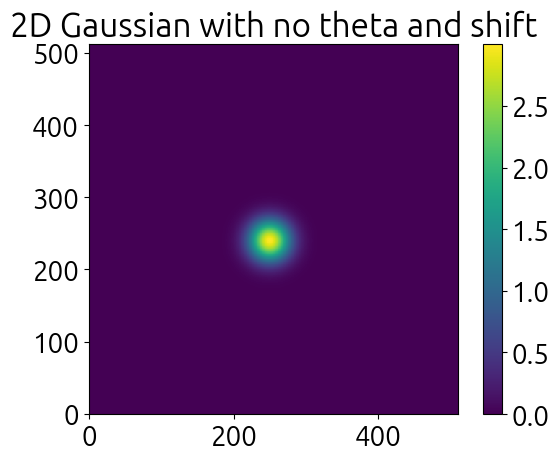

In [13]:

x = np.linspace(0, 512, 512)
xx, yy = np.meshgrid(x, x)
plt.title("2D Gaussian with no theta and shift")
#plt.figure(figsize=(12,5),dpi=300)
data = TwoDGaussian( (xx, yy),3, 250, 20, 240, 20)
#data = TwoDGaussianEllipticalFlat( (xx, yy),3, 250, 20, 240, 20, 0, 500)

#plt.subplot(1,2,1)
plt.imshow(data.reshape(512,512),interpolation='nearest',origin='lower')
plt.colorbar()
#plt.subplot(1,2,2)
#plt.imshow(data.reshape(512,512),interpolation='nearest',origin='lower')
#create data.optimize
#data = TwoDGaussianEllipticalFlat( (xx, yy),3, 250, 20, 240, 20, 0, 500)
# plot twoD_Gaussian data generated above


In [14]:
#Particles=PickleITRead("/home/ilker/Downloads/imgs.p")

In [15]:
##### 3 Source in a picture

#Images=getImageValues(ListofFiles("/home/argon/Downloads/15_8_7/1s/"),-1)
#Images=getImageValues(ListofFiles("/media/argon/Data/CRAB_Diffusion_Data/CRAB_6_15_2023_10bar/17/1s/"),-1)
#Images=getImageValues(ListofFiles("/media/ilker/Ilker/CRAB_6_15_2023_10bar/Collected/15k_8k_7k/14ms/"),-1)


In [16]:
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="lm")
    #print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt
    

In [17]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=round(Fit[3][i]*pixelSize,2)
        DTY=round(Fit[3][i+2]*pixelSize,2)
        DT=round((DTX+DTY)/2,2)*mag
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
    

In [18]:
def SingleFitImage(AverageImage,c1,c2,c3):
    distance=5
    pixelSize=16e-3 #mm
    Magnefication=1/0.064
    
    NeedleDistances=np.array([5.46,10.58,15.55]) #cm

    PixelShape=AverageImage.shape


    #Estimating the Amplitudes
    
   
    Needle15cm_Mask=MaskCreate(PixelShape,20,c1)

    Needle10cm_Mask=MaskCreate(PixelShape,20,c2)

    Needle5cm_Mask=MaskCreate(PixelShape,20,c3)
    
    #providing initial values
    initialGuess_needle_5cm=np.mean(AverageImage[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0], 30, Needle5cm_Mask[2][1],30
    initialGuess_needle_10cm=np.mean(AverageImage[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 25, Needle10cm_Mask[2][1],25
    initialGuess_needle_15cm=np.mean(AverageImage[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 18, Needle15cm_Mask[2][1],18

    offset=0.1
    
    #Fitting with initial values
    Fit_3Gaussian=FitSumsof3Gaussian(AverageImage,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)
    
    #Converting from pixel to mm
    Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,Magnefication)
    
    ## Getting the slope
    slope, intercept = np.polyfit(NeedleDistances, Diffusion[0]**2, 1)
    

    DT=np.round(np.sqrt(slope),2)
    Intercept=np.round(np.sqrt(intercept),2)
    return DT,Intercept,Diffusion[0]**2,Fit_3Gaussian

def MultiImageFitting(Iteration,Imgs,amount,c1,c2,c3):
    #### For Multiple images
    if(len(Imgs.keys())<Iteration):
        Iteration=len(Imgs.keys())
    NumberOfImages=np.arange(Iteration,amount+Iteration,Iteration)
    values={"DTs":np.array([]),"Intercepts":np.array([]),"5cm":np.array([]),"10cm":np.array([]),"15cm":np.array([])}
    count=0
    vv=[]
    for imgs in NumberOfImages:
        ImageLayout=np.ones((512,512))
        
        ## AverageIt
        for img in range(imgs-Iteration,imgs):
            ImageLayout=ImageLayout+Imgs[img]
        
        ImageLayout=ImageLayout/Iteration
        ## Fit return values DT,Intercept,sigma^2                   
        vv=SingleFitImage(ImageLayout,c1,c2,c3)
        values["DTs"]=np.append(values["DTs"],vv[0])
        values["Intercepts"]=np.append(values["Intercepts"],vv[1])   
        values["5cm"]=np.append(values["5cm"],vv[2][0])
        values["10cm"]=np.append(values["10cm"],vv[2][1])
        values["15cm"]=np.append(values["15cm"],vv[2][2])
    return values

In [19]:
#OlPostImgs=PickleITRead("/media/ilker/Ilker_SSD/CRAB_Pickle/15k_8k_7k_14ms_oldpos.p")
OlPostImgs=getImageValues(ListofFiles("/media/argon/Ilker_SSD/June_18_CRAB_Pictures/17k_8k_7k/",True),-1)


 0 frames in dictinary 


In [20]:
### Iteration,Images,TotalImage,Center1,Center2,Center3
kk=MultiImageFitting(100,OlPostImgs,24300,(215,270),(298,297),(256,189))

ZeroDivisionError: division by zero

In [ ]:
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
NeedleDistances=np.array([5.46,10.58,15.55])

AverageValue=[np.mean(kk["5cm"]),np.mean(kk["10cm"]),np.mean(kk["15cm"])]
Error=[np.std(kk["5cm"]),np.std(kk["10cm"]),np.std(kk["15cm"])]
#NeedleDistances=np.sqrtNeedleDistances)

p, v = np.polyfit(NeedleDistances,AverageValue, 1,cov=True)
plt.errorbar(NeedleDistances,AverageValue,yerr=Error,fmt="o")
plt.plot(NeedleDistances,(p[0]*NeedleDistances+p[1]))

DT=np.round(np.sqrt(p[0]),2)

print(np.sqrt(p[0]),np.sqrt(p[1]))

plt.text(0.4,0.85,f"DT = {DT} " + r"$\pm{} $" + f"{round(np.sqrt(v[0][0]),2)}" + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(p[0],2)}x + {round(p[1],2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(np.mean(kk["DTs"]))
print(np.std(kk["DTs"]))
print(np.sqrt(Error))


print("x_1: {} +/- {}".format(p[0], np.sqrt(v[0][0])))
print("x_2: {} +/- {}".format(p[1], np.sqrt(v[1][1])))

meanDT=np.mean(kk["DTs"])
stdDT=np.std(kk["DTs"])

meanb=np.mean(kk["Intercepts"])
stdb=np.std(kk["Intercepts"])
print("mean slope: {} +/- {}".format(meanDT**2, stdDT**2))
print("mean intercept: {} +/- {}".format(meanb**2, stdb**2))

In [ ]:
#CurrentImages=PickleITRead("/media/ilker/Ilker_SSD/CRAB_Pickle/15k_8k_7k_14ms.p")
CurrentImages=getImageValues(ListofFiles("/media/argon/Ilker/CRAB_6_15_2023_10bar/17/14ms/",True),-1)


In [ ]:
kk2=MultiImageFitting(100,CurrentImages,10000,(215,270),(298,297),(256,189))



In [ ]:
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
NeedleDistances=np.array([5.46,10.58,15.55])

AverageValue=[np.mean(kk2["5cm"]),np.mean(kk2["10cm"]),np.mean(kk2["15cm"])]
Error=[np.std(kk2["5cm"]),np.std(kk2["10cm"]),np.std(kk2["15cm"])]
#NeedleDistances=np.sqrtNeedleDistances)

p, v = np.polyfit(NeedleDistances,AverageValue, 1,cov=True)
plt.errorbar(NeedleDistances,AverageValue,yerr=Error,fmt="o")
plt.plot(NeedleDistances,(p[0]*NeedleDistances+p[1]))

DT=np.round(np.sqrt(p[0]),2)

print(np.sqrt(p[0]),np.sqrt(p[1]))

plt.text(0.4,0.85,f"DT = {DT} " + r"$\pm{} $" + f"{round(np.sqrt(np.sqrt(v[0][0])),2)}" + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(p[0],2)}x + {round(p[1],2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(np.mean(kk2["DTs"]))
print(np.std(kk2["DTs"]))
print(np.sqrt(Error))


print("x_1: {} +/- {}".format(p[0], np.sqrt(v[0][0])))
print("x_2: {} +/- {}".format(p[1],np.sqrt(v[1][1])))
print(Error)